**Walmart Sales**

In this project, we will be looking at the weekly sales figures of Walmart stores. The aim is to be able to predict store sales based on social and economic criteria.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

In [2]:
#import dataset
sales = pd.read_csv('Walmart_Store_sales.csv')
pd.options.display.max_columns = None
sales.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


# Data exploration and cleaning


In [3]:
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
display(sales.describe(include='all'))
print()
print("Percentage of missing values: ")
display(100*sales.isnull().sum()/sales.shape[0])

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000



Percentage of missing values: 


Store            0.000000
Date            12.000000
Weekly_Sales     9.333333
Holiday_Flag     8.000000
Temperature     12.000000
Fuel_Price       9.333333
CPI              8.000000
Unemployment    10.000000
dtype: float64

In [5]:
sales.duplicated().value_counts()

False    150
dtype: int64

In [6]:
# remove lines with missing targets to avoid bias
sales.dropna(subset=['Weekly_Sales'], inplace=True)

In [7]:
#fill the missing values with the most frequent value for categorical variable
# Holiday flag
sales['Holiday_Flag'].fillna(0, inplace = True) # not holiday time

# Date
most_frequent_date = sales['Date'].mode()[0]
sales['Date'].fillna(most_frequent_date, inplace=True)

In [8]:
#fill the missing values with the mean value for numerical variable
mean_temperature = sales['Temperature'].mean()
mean_cpi = sales['CPI'].mean()
mean_unemployment = sales['Unemployment'].mean()
mean_fuel = sales['Fuel_Price'].mean()

sales['Temperature'].fillna(mean_temperature, inplace=True)
sales['CPI'].fillna(mean_cpi, inplace=True)
sales['Unemployment'].fillna(mean_unemployment, inplace=True)
sales['Fuel_Price'].fillna(mean_fuel, inplace=True)

In [9]:
display(sales.describe(include='all'))

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,136.000000,136,1.360000e+02,136.000000,136.000000,136.000000,136.000000,136.000000
unique,NaN,79,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,10-12-2010,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,21,NaN,NaN,NaN,NaN,NaN,NaN
mean,10.014706,NaN,1.249536e+06,0.066176,60.853967,3.316992,178.091144,7.665582
std,6.124614,NaN,6.474630e+05,0.249509,17.455574,0.457731,38.568739,1.533160
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,48.072500,2.853750,132.464884,6.833000
50%,10.000000,NaN,1.261424e+06,0.000000,60.853967,3.316992,189.613975,7.661791
75%,15.250000,NaN,1.806386e+06,0.000000,75.175000,3.689750,214.756314,8.100750


In [10]:
# drop outliers 'Fuel_price'
mean_fuel_price = sales['Fuel_Price'].mean()
std_fuel_price = sales['Fuel_Price'].std()
mask_fuel_price = (sales['Fuel_Price'] > mean_fuel_price - 3 * std_fuel_price) & (sales['Fuel_Price'] < mean_fuel_price + 3 * std_fuel_price)
sales = sales[mask_fuel_price]

# drop outliers 'Unemployment'
mean_unemployment = sales['Unemployment'].mean()
std_unemployment = sales['Unemployment'].std()
mask_unemployment = (sales['Unemployment'] > mean_unemployment - 3 * std_unemployment) & (sales['Unemployment'] < mean_unemployment + 3 * std_unemployment)
sales = sales[mask_unemployment]

display(sales.describe(include='all'))

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,131.000000,131,1.310000e+02,131.000000,131.000000,131.000000,131.000000,131.000000
unique,NaN,78,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,10-12-2010,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,21,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.938931,NaN,1.257990e+06,0.061069,60.453783,3.304198,180.000711,7.427871
std,6.228663,NaN,6.577463e+05,0.240376,17.444613,0.452979,38.009862,0.942684
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,5.842439e+05,0.000000,47.085000,2.851500,133.361048,6.833000
50%,9.000000,NaN,1.366396e+06,0.000000,60.853967,3.316992,192.826069,7.567000
75%,16.000000,NaN,1.809576e+06,0.000000,75.045000,3.683000,214.781675,8.059000


In [11]:
display(100*sales.isnull().sum()/sales.shape[0])

Store           0.0
Date            0.0
Weekly_Sales    0.0
Holiday_Flag    0.0
Temperature     0.0
Fuel_Price      0.0
CPI             0.0
Unemployment    0.0
dtype: float64

In [12]:
# Date column
sales['Date'] = pd.to_datetime(sales['Date'])
sales['Year'] = sales['Date'].dt.year
sales['day_of_week'] = sales['Date'].dt.dayofweek
sales['Month'] = sales['Date'].dt.month
sales['Day'] = sales['Date'].dt.day

display(sales.head())

<ipython-input-12-b3fd0f50331b>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  sales['Date'] = pd.to_datetime(sales['Date'])


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,day_of_week,Month,Day
0,6.0,2011-02-18,1572117.54,0.0,59.610000,3.045000,214.777523,6.858,2011,4,2,18
1,13.0,2011-03-25,1807545.43,0.0,42.380000,3.435000,128.616064,7.470,2011,4,3,25
3,11.0,2010-10-12,1244390.03,0.0,84.570000,3.316992,214.556497,7.346,2010,1,10,12
4,6.0,2010-05-28,1644470.66,0.0,78.890000,2.759000,212.412888,7.092,2010,4,5,28
5,4.0,2010-05-28,1857533.70,0.0,60.853967,2.756000,126.160226,7.896,2010,4,5,28


In [13]:
sales['day_of_week'].value_counts()

4    79
1    27
6     9
3     8
0     4
5     4
Name: day_of_week, dtype: int64

In [15]:
sales['Store'].value_counts()

3.0     12
18.0    10
14.0     9
1.0      9
13.0     9
7.0      8
19.0     8
5.0      8
2.0      8
17.0     7
6.0      6
8.0      6
4.0      6
20.0     5
10.0     5
15.0     4
16.0     4
9.0      4
11.0     3
Name: Store, dtype: int64

In [16]:
# Visualize pairwise dependencies

fig = px.scatter_matrix(sales)
fig.update_layout(
        title = go.layout.Title(text = "Bivariate analysis", x = 0.5), showlegend = False,
            autosize=False, height = 1200, width = 1200)
fig.show()

<Figure size 1500x1500 with 0 Axes>

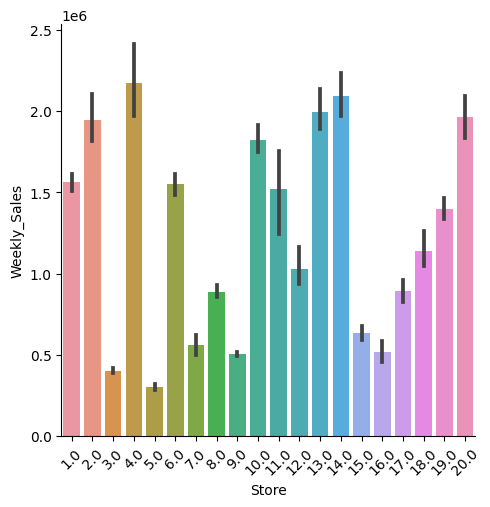

In [ ]:
plt.figure(figsize = (15,15))
sns.catplot(x="Store", y="Weekly_Sales", kind="bar", data=sales)
plt.xticks(rotation=45);

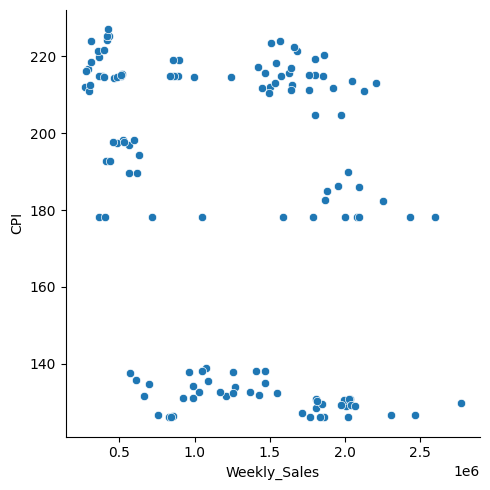

In [ ]:
sns.relplot(x="Weekly_Sales", y="CPI", data=sales)

<Axes: >

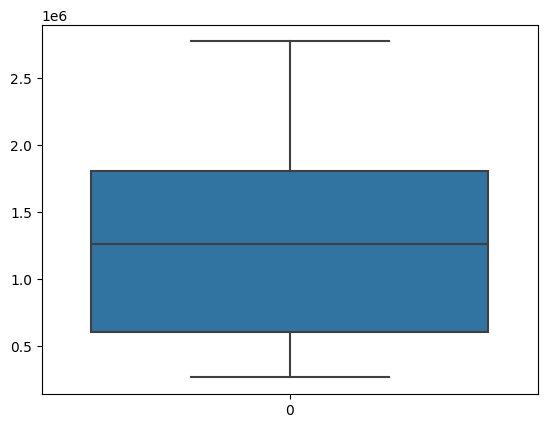

In [ ]:
# Boxplot
sns.boxplot(sales['Weekly_Sales'])

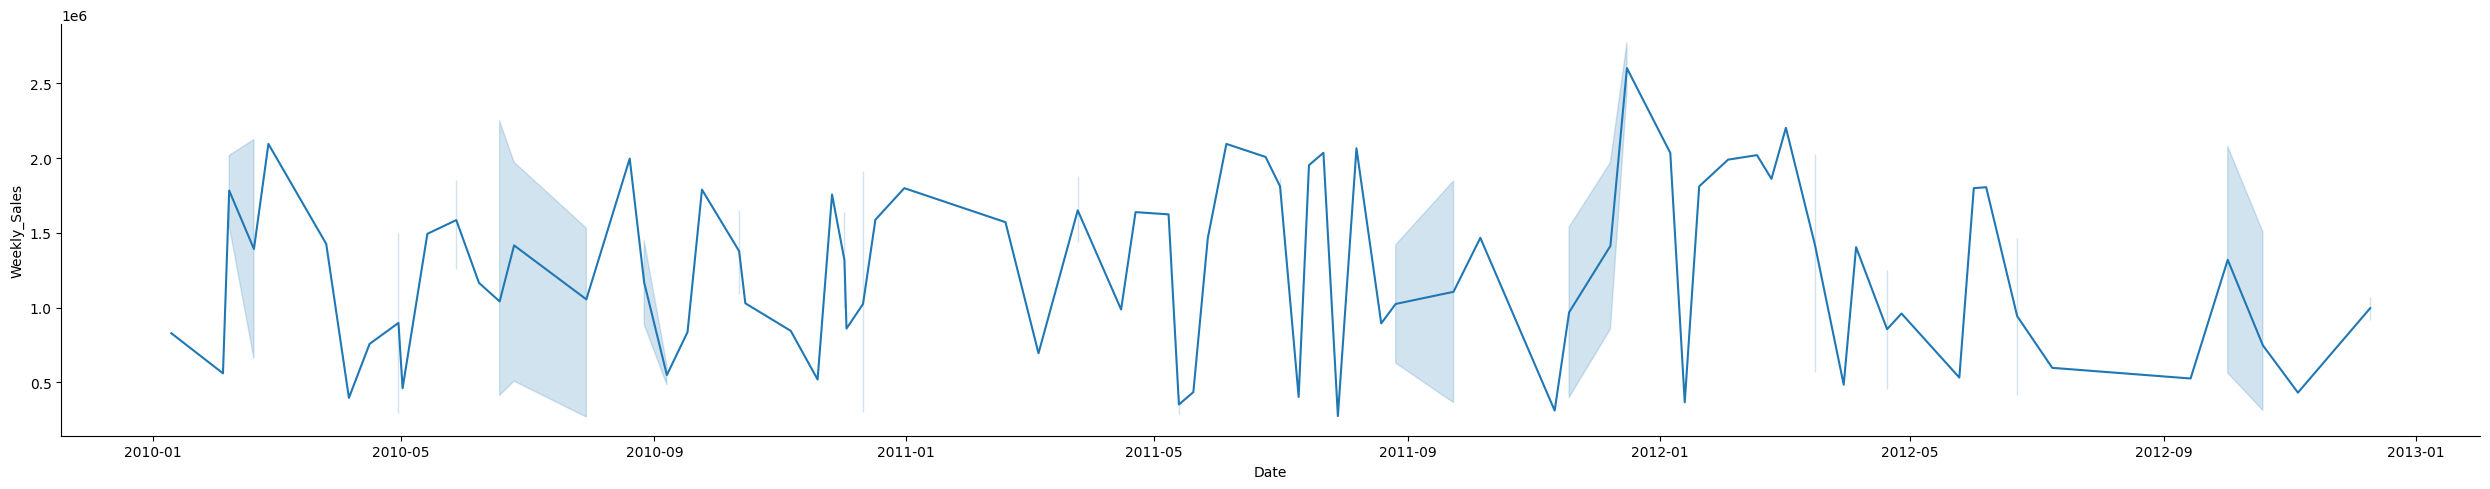

In [18]:
# Mean Weekly_Sales over the year
sales['Date'] = pd.to_datetime(sales['Date'])
sns.relplot(x="Date", y="Weekly_Sales", data = sales, kind="line", height = 5, aspect = 5)

In [17]:
# Correlation matrix
import plotly.figure_factory as ff
corr_matrix = sales.corr().round(2)

fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.tolist(),
                                  y = corr_matrix.index.tolist())


fig.show()

<ipython-input-17-cbb69257ad9c>:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



## EDA SUM UP

<div align="Justify">

We have a very small dataset, only 150 lines, with many missing values. I remove the rows with the missing target value to avoid creating a bias. And I fill in the missing values in the other columns with the mode or average. We could have removed them completely, but the dataset is already very small, and there would be very few rows left to train a model by removing them.

As requested in the instructions, we remove the tools for numerical variables that are more than 3 standard deviations from the mean. This concerns excessively high values in the unemployment and petrol columns.

On our first graph showing the relationships between two variables, there is no variable that forms a clean linear regression at first sight with weekly sales. But on the other hand, with stores, we can see 3 straight line formations, on 3 different levels. In the correlation matrix, there is no strong correlation with weekly sales. On the positive side, there's a link with the unemployment rate at 0.17, obviously the higher it is, the greater the increase in sales, 0.12 with the store concerned. Conversely, the CPI has a strong negative correlation rate at -0.3, and the same applies to temperature at -0.15.

Average sales vary widely from store to store. And no regularity in the timeline. The CPI (consumer price index) represents the evolution of prices through inflation. It's difficult to analyze here, because we can see 3 distinct levels. But it seems logical that if prices are rising, people with less purchasing power will spend less in the store. As for unemployment, if people spending money at Walmart are more likely to be affected by high unemployment, it's because it's an expensive superstore for the USA.

All these are interesting social and economic criteria, which suggest that the store's environment - whether it's in a more privileged neighborhood or not - plays a strong role in weekly sales.

To confirm this hypothesis, we'll use the "store" variable in the baseline.


</div>

# Baseline linear regression

##preprocessing

In [29]:
# Separate target variable Y from features X
target_name = 'Weekly_Sales'
features_list = ['Store']

print("Separating labels from features...")
X = sales.loc[:,features_list]
Y = sales.loc[:,target_name]

print("...Done.")
print(Y.head())
print()
print(X.head())
print()

Separating labels from features...
...Done.
0    1572117.54
1    1807545.43
3    1244390.03
4    1644470.66
5    1857533.70
Name: Weekly_Sales, dtype: float64

   Store
0    6.0
1   13.0
3   11.0
4    6.0
5    4.0



In [30]:
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [31]:
print("Preprocessing X_train...")
print(X_train.head())
print()
ohe = OneHotEncoder()
X_train = ohe.fit_transform(X_train)
print("...Done!")
print(X_train[0:5,:])

Preprocessing X_train...
     Store
136    4.0
78     1.0
17    18.0
108   18.0
141    5.0

...Done!
  (0, 3)	1.0
  (1, 0)	1.0
  (2, 16)	1.0
  (3, 16)	1.0
  (4, 4)	1.0


In [32]:
print("Preprocessing X_test...")
print(X_test.head())
print()
X_test = ohe.transform(X_test)
print("...Done!")
print(X_test[0:5,:])

Preprocessing X_test...
     Store
9      3.0
67     3.0
102   18.0
120    8.0
81     5.0

...Done!
  (0, 2)	1.0
  (1, 2)	1.0
  (2, 16)	1.0
  (3, 7)	1.0
  (4, 4)	1.0


##model

In [33]:
# Train model
print("Train model...")
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [34]:
# Print R^2 scores
print("R2 score on training set : ", regressor.score(X_train, Y_train))
print("R2 score on test set : ", regressor.score(X_test, Y_test))

R2 score on training set :  0.9576340393231997
R2 score on test set :  0.9236735851350241


In [35]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = regressor.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[2173758.98333333 1542319.09571429 1188903.41166667 1188903.41166667
  293682.23666667  913917.15333333 2015960.965      2015960.965
  515317.7725     2015960.965      1399987.75428571  391027.10428571
 1962384.412      1551123.58       1399987.75428571 1962384.412
 2052948.62428571 2052948.62428571 1663425.225      1962384.412
 2015960.965      1863406.45333333 1982229.07166667  633580.4025
 1551123.58        536664.40142857 1542319.09571429  536664.40142857
  506095.44       1982229.07166667 1399987.75428571  901750.04
 1982229.07166667 2052948.62428571 1188903.41166667 2015960.965
 1863406.45333333  901750.04        536664.40142857  293682.23666667
 2173758.98333333 1982229.07166667 1542319.09571429  633580.4025
 1551123.58       1551123.58        293682.23666667 1551123.58
 2173758.98333333  536664.40142857 2052948.62428571  913917.15333333
  293682.23666667  913917.15333333 1982229.07166667 1399987.75428571
 1399987.75428571  293682.23666667

In [36]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = regressor.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[ 391027.10428571  391027.10428571 1188903.41166667  901750.04
  293682.23666667 1982229.07166667 1542319.09571429 1188903.41166667
 1188903.41166667  913917.15333333 1982229.07166667 2052948.62428571
 1399987.75428571  536664.40142857 1188903.41166667  506095.44
 2052948.62428571  391027.10428571 1663425.225      1863406.45333333
  901750.04        391027.10428571  391027.10428571 2015960.965
 1863406.45333333 1542319.09571429  293682.23666667]



In [48]:
X_train.shape

(104, 1)

In [49]:
X_test.shape

(27, 1)

## Baseline SUM UP

<div align="Justify">

In this baseline with the Store variable, we can see that the model is already good with a single variable. It obtains 0.95 on the R2 score on the train set and 0.92 on the test set. The R2 score represents the model's performance, being close to 0 if the sum of residual squares (SSR) is close to the sum of total squares (SST). And on the contrary, if the model proudly explains the target variable with predictions as close as possible, then the R2 score will be close to 1. We can see an overfitting, but the number of data is really very small, and this should be taken into account. For the next model, we'll use all the variables and make the model more complex to see if we can improve performance.

</div>

# Model with all variables

## Preprocessing

In [50]:
sales.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'day_of_week', 'Month',
       'Day'],
      dtype='object')

In [51]:
# Separate target variable Y from features X
target_name = 'Weekly_Sales'
features_list = ['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'day_of_week', 'Month', 'Day']

print("Separating labels from features...")
X = sales.loc[:,features_list]
Y = sales.loc[:,target_name]

print("...Done.")
print(Y.head())
print()
print(X.head())
print()

Separating labels from features...
...Done.
0    1572117.54
1    1807545.43
3    1244390.03
4    1644470.66
5    1857533.70
Name: Weekly_Sales, dtype: float64

   Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
0    6.0           0.0    59.610000    3.045000  214.777523         6.858   
1   13.0           0.0    42.380000    3.435000  128.616064         7.470   
3   11.0           0.0    84.570000    3.316992  214.556497         7.346   
4    6.0           0.0    78.890000    2.759000  212.412888         7.092   
5    4.0           0.0    60.853967    2.756000  126.160226         7.896   

   Year  day_of_week  Month  Day  
0  2011            4      2   18  
1  2011            4      3   25  
3  2010            1     10   12  
4  2010            4      5   28  
5  2010            4      5   28  



In [52]:
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [53]:
# Create pipeline for numeric features
numeric_features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'Day']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_features = ['Store', 'Holiday_Flag', 'day_of_week']
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first'))
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5])
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head())
X_test = preprocessor.transform(X_test)
print('...Done.')
print(X_test[0:5,:])
print()

Performing preprocessings on train set...
     Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
136    4.0           0.0        84.59    3.469000  129.112500      5.644000   
78     1.0           0.0        62.25    3.308000  218.220509      7.866000   
17    18.0           0.0        21.33    2.788000  131.527903      9.202000   
108   18.0           0.0        69.12    2.906000  132.293936      7.665582   
141    5.0           0.0        62.37    3.316992  212.560411      6.768000   

     Year  day_of_week  Month  Day  
136  2011            6      8    7  
78   2011            4     11   18  
17   2010            1     10   12  
108  2010            4      5   28  
141  2010            5     12   11  
...Done.
  (0, 0)	1.4635714591226585
  (0, 1)	0.3418981471186464
  (0, 2)	-1.3310962801203026
  (0, 3)	-1.8533177069412874
  (0, 4)	0.284427277884051
  (0, 5)	0.27448934435270567
  (0, 6)	-1.115180222028255
  (0, 9)	1.0
  (0, 30)	1.0
  (1, 0)	0.1393043113347780

## Model

In [54]:
# Train model
print("Train model...")
all_variables_regressor = LinearRegression()
all_variables_regressor.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [55]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = all_variables_regressor.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = all_variables_regressor.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on training set...
...Done.
[2228771.9422101  1606050.1494463  1278463.22482146 1203675.52229373
  277132.93767219  892933.97469881 2107980.25778363 2021301.7950783
  410405.97530105 2052064.30906304 1425691.84741375  439585.74185318
 1987138.02066637 1553393.9336215  1471979.67887012 1961217.65870732
 2099588.06670157 2015560.01500016 1616041.933589   1907076.08841718
 2013245.33420045 1777275.62480178 2039139.45234641  659322.39165182
 1561477.24549975  559308.63478396 1451031.24624885  542269.52436602
  452399.58997089 1990948.35323655 1339971.69358103 1036842.22007991
 1859615.76740917 2013082.62113811 1320843.62247954 1921627.03349665
 1911536.29124334 1018648.82572664  491302.45204599  306522.20270006
 2026732.72244703 2020920.54566993 1582181.01460266  631132.40494324
 1629111.84558649 1470232.05934409  179230.29820905 1546923.61633323
 2077105.00983003  659220.04929806 2090272.50516028  929391.67597669
  412132.63622147  967946.92738493 2028777.73708703 1374664.6869

In [56]:
# Print R^2 scores
print("R2 score on training set : ", all_variables_regressor.score(X_train, Y_train))
print("R2 score on test set : ", all_variables_regressor.score(X_test, Y_test))

R2 score on training set :  0.9684425884354547
R2 score on test set :  0.9250192698586667


In [57]:
all_variables_regressor.coef_

array([  -29310.78786044,   -41441.51214307,    40829.96435399,
         -74203.22673762,   -20024.98076089,    52822.40345544,
         -29841.33522383,   382079.29204061, -1230680.18136974,
         573496.36355754, -1346628.40188743,   -25079.22064571,
        -906902.78524565,  -804096.80333754, -1240376.15619393,
         528859.49416799,    20626.48447497,   507241.91196361,
         635283.81325615,  -768933.26027335, -1099475.00640857,
        -666993.04703061,  -246169.06392768,    -5048.60861637,
         369046.95758221,   -66175.96626648,    33404.40926009,
          10777.16398447,    65666.36437714,   -61315.7755185 ,
          96581.77124879])

In [58]:
column_names = []
for name, pipeline, features_list in preprocessor.transformers_: # loop over pipelines
    if name == 'num': # if pipeline is for numeric variables
        features = features_list # just get the names of columns to which it has been applied
    else: # if pipeline is for categorical variables
        features = pipeline.named_steps['encoder'].get_feature_names_out() # get output columns names from OneHotEncoder
    column_names.extend(features) # concatenate features names

print("Names of columns corresponding to each coefficient: ", column_names)


Names of columns corresponding to each coefficient:  ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'Day', 'Store_2.0', 'Store_3.0', 'Store_4.0', 'Store_5.0', 'Store_6.0', 'Store_7.0', 'Store_8.0', 'Store_9.0', 'Store_10.0', 'Store_11.0', 'Store_13.0', 'Store_14.0', 'Store_15.0', 'Store_16.0', 'Store_17.0', 'Store_18.0', 'Store_19.0', 'Store_20.0', 'Holiday_Flag_1.0', 'day_of_week_1', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6']


In [59]:
# Create a pandas DataFrame
coefs = pd.DataFrame(index = column_names, data = all_variables_regressor.coef_.transpose(), columns=["coefficients"])
coefs

,coefficients
Temperature,-2.931079e+04
Fuel_Price,-4.144151e+04
CPI,4.082996e+04
Unemployment,-7.420323e+04
Year,-2.002498e+04
Month,5.282240e+04
Day,-2.984134e+04
Store_2.0,3.820793e+05
Store_3.0,-1.230680e+06
Store_4.0,5.734964e+05


In [60]:
# Compute abs() and sort values
feature_importance = abs(coefs).sort_values(by = 'coefficients')
feature_importance

,coefficients
Store_19.0,5.048609e+03
day_of_week_3,1.077716e+04
Year,2.002498e+04
Store_11.0,2.062648e+04
Store_6.0,2.507922e+04
Temperature,2.931079e+04
Day,2.984134e+04
day_of_week_1,3.340441e+04
CPI,4.082996e+04
Fuel_Price,4.144151e+04


In [66]:
# Plot coefficients
fig = px.bar(feature_importance)
fig.update_layout(showlegend = False)
fig.show()

## Linear regression with all variables SUM UP

<div align="Justify">

By adding all the variables, we can see that the model has made further progress on the training set. But not on the test set. It is overfitting. In terms of variable importance, certain stores have a strong impact on sales. We also have the unemployment rate, and certain temporal factors which have a significant impact. Generally speaking, the store concerned has a greater influence on the model than other factors.

To combat overfitting, we're going to regularize the model and see if it can get rid of or reduce the impact of variables that are of little importance.

</div>

# Regularization

## Preprocessing

In [67]:
# Separate target variable Y from features X
target_name = 'Weekly_Sales'
features_list = ['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'day_of_week', 'Month', 'Day']

print("Separating labels from features...")
X = sales.loc[:,features_list]
Y = sales.loc[:,target_name]

print("...Done.")
print(Y.head())
print()
print(X.head())
print()

Separating labels from features...
...Done.
0    1572117.54
1    1807545.43
3    1244390.03
4    1644470.66
5    1857533.70
Name: Weekly_Sales, dtype: float64

   Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
0    6.0           0.0    59.610000    3.045000  214.777523         6.858   
1   13.0           0.0    42.380000    3.435000  128.616064         7.470   
3   11.0           0.0    84.570000    3.316992  214.556497         7.346   
4    6.0           0.0    78.890000    2.759000  212.412888         7.092   
5    4.0           0.0    60.853967    2.756000  126.160226         7.896   

   Year  day_of_week  Month  Day  
0  2011            4      2   18  
1  2011            4      3   25  
3  2010            1     10   12  
4  2010            4      5   28  
5  2010            4      5   28  



In [68]:
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [69]:
# Create pipeline for numeric features
numeric_features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'Day']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_features = ['Store', 'Holiday_Flag', 'day_of_week']
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first'))
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5])
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head())
X_test = preprocessor.transform(X_test)
print('...Done.')
print(X_test[0:5,:])
print()

Performing preprocessings on train set...
     Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
136    4.0           0.0        84.59    3.469000  129.112500      5.644000   
78     1.0           0.0        62.25    3.308000  218.220509      7.866000   
17    18.0           0.0        21.33    2.788000  131.527903      9.202000   
108   18.0           0.0        69.12    2.906000  132.293936      7.665582   
141    5.0           0.0        62.37    3.316992  212.560411      6.768000   

     Year  day_of_week  Month  Day  
136  2011            6      8    7  
78   2011            4     11   18  
17   2010            1     10   12  
108  2010            4      5   28  
141  2010            5     12   11  
...Done.
  (0, 0)	1.4635714591226585
  (0, 1)	0.3418981471186464
  (0, 2)	-1.3310962801203026
  (0, 3)	-1.8533177069412874
  (0, 4)	0.284427277884051
  (0, 5)	0.27448934435270567
  (0, 6)	-1.115180222028255
  (0, 9)	1.0
  (0, 30)	1.0
  (1, 0)	0.1393043113347780

## Model

In [70]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score

### Ridge regularization

In [71]:
# Perform grid search
print("Grid search...")
all_variables_ridge = Ridge()
# Grid of values to be tested
params = {
    'alpha': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
}
best_ridge = GridSearchCV(all_variables_ridge, param_grid = params, cv = 5)
best_ridge.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", best_ridge.best_params_)
print("Best R2 score : ", best_ridge.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'alpha': 0.05}
Best R2 score :  0.9240444025920438


In [72]:
# Print R^2 scores
print("R2 score on training set : ", best_ridge.score(X_train, Y_train))
print("R2 score on test set : ", best_ridge.score(X_test, Y_test))

R2 score on training set :  0.9680423768417548
R2 score on test set :  0.9277718718112158


In [74]:
scores = cross_val_score(best_ridge.best_estimator_, X_train, Y_train, cv = 10)

print('The cross-validated R2-score is : ', scores.mean())
print('The standard deviation is : ', scores.std())

The cross-validated R2-score is :  0.9208555688287785
The standard deviation is :  0.04856652361923156


### Lasso regularization

In [75]:
# Perform grid search
print("Grid search...")
all_variables_lasso = Lasso()
# Grid of values to be tested
params = {
    'alpha': [1, 2, 3, 5, 10, 20, 30]
}
best_lasso = GridSearchCV(all_variables_lasso, param_grid = params, cv = 5) # cv : the number of folds to be used for CV
best_lasso.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", best_lasso.best_params_)
print("Best R2 score : ", best_lasso.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'alpha': 30}
Best R2 score :  0.9224098589726125


In [76]:
# Print R^2 scores
print("R2 score on training set : ", best_lasso.score(X_train, Y_train))
print("R2 score on test set : ", best_lasso.score(X_test, Y_test))

R2 score on training set :  0.9684397284224843
R2 score on test set :  0.9255220144016996


In [77]:
scores = cross_val_score(best_lasso.best_estimator_, X_train, Y_train, cv = 10)

print('The cross-validated R2-score is : ', scores.mean())
print('The standard deviation is : ', scores.std())

The cross-validated R2-score is :  0.9188916866524457
The standard deviation is :  0.04594695895333932


## Performance

In [78]:
# Print R^2 scores
print("RIDGE / R2 score on training set : ", best_ridge.score(X_train, Y_train))
print("RIDGE / R2 score on test set : ", best_ridge.score(X_test, Y_test))
print()
print("LASSO / R2 score on training set : ", best_lasso.score(X_train, Y_train))
print("LASSO / R2 score on test set : ", best_lasso.score(X_test, Y_test))

RIDGE / R2 score on training set :  0.9680423768417548
RIDGE / R2 score on test set :  0.9277718718112158

LASSO / R2 score on training set :  0.9684397284224843
LASSO / R2 score on test set :  0.9255220144016996


In [80]:
column_names = []
for name, pipeline, features_list in preprocessor.transformers_: # loop over pipelines
    if name == 'num': # if pipeline is for numeric variables
        features = features_list # just get the names of columns to which it has been applied
    else: # if pipeline is for categorical variables
        features = pipeline.named_steps['encoder'].get_feature_names_out() # get output columns names from OneHotEncoder
    column_names.extend(features) # concatenate features names

print("Names of columns corresponding to each coefficient: ", column_names)

Names of columns corresponding to each coefficient:  ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'Day', 'Store_2.0', 'Store_3.0', 'Store_4.0', 'Store_5.0', 'Store_6.0', 'Store_7.0', 'Store_8.0', 'Store_9.0', 'Store_10.0', 'Store_11.0', 'Store_13.0', 'Store_14.0', 'Store_15.0', 'Store_16.0', 'Store_17.0', 'Store_18.0', 'Store_19.0', 'Store_20.0', 'Holiday_Flag_1.0', 'day_of_week_1', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6']


In [82]:
data_dict = {
    'Feature': column_names,
    'Best_Ridge': best_ridge.best_estimator_.coef_,
    'Best_Lasso': best_lasso.best_estimator_.coef_
            }

coefficients = pd.DataFrame(data = data_dict)
coefficients

,Feature,Best_Ridge,Best_Lasso
0,Temperature,-2.817822e+04,-2.913197e+04
1,Fuel_Price,-3.734474e+04,-4.109508e+04
2,CPI,3.765800e+04,4.102703e+04
3,Unemployment,-5.777035e+04,-7.313329e+04
4,Year,-1.811527e+04,-2.014463e+04
5,Month,5.082784e+04,5.241976e+04
6,Day,-3.154207e+04,-3.002710e+04
7,Store_2.0,4.173985e+05,3.837576e+05
8,Store_3.0,-1.176478e+06,-1.227384e+06
9,Store_4.0,6.232480e+05,5.773802e+05


In [83]:
X_train.shape

(104, 31)

In [84]:
X_test.shape

(27, 31)

## Regularization SUM UP

<div align="Justify">

The aim of regularization is to constrain the model. Lasso can completely forget certain variables that don't have much weight, whereas Ridge reduces all the model's coefficients.  The alpha parameter represents the strength of regularization: the higher the alpha, the stronger is the constraint.

In this example, we can see that the two regularizations have similar scores and have left similar weights on the variables, while Lasso has not set any coefficients to 0.

This regularization does not solve the overfitting problem and does not improve model performance. We obtain values of around 0.96 on the train set for both the regularized and non-regularized models, and values of around 0.92 for the test set. Bear in mind that we only have 104 lines in the train set and 27 in the test set. This is a very small dataset, and proportionately many explanatory variables, which has an impact on model training.


</div>

# Conclusion

<div align="Justify">

Dataset size plays an important role here. We have very little data, and many of these have been filled in at the beginning by replacing missing values with the mean or mode. With so little data, it's easy for the model to learn the data by heart, but it won't be able to generalize correctly.

To refine the predictions for each date, we would need more data per store and on a fuller time line, to be able to make predictions on time series.  

The analysis and models show that the store concerned has a strong impact on the result. Through its location, the store represents the environment and the social and economic factors of the area in which it is present.

Walmart could very well use these predictive models to predict weekly sales, but must bear in mind that there is a margin of error in the model's ability to generalize and/or increase its data volume before using this model.


</div>